# 0. Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym

# 1. Define the Environment and the Model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env_id = "LunarLander-v2"

env = gym.make(env_id)

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [4]:
class PolicyNetwork(nn.Module):
    """
    The Policy Network (Actor).
    """
    def __init__(self, s_size, a_size, h_size):
        '''
        Initialise the policy network.
        '''
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(s_size, h_size)
        self.layer2 = nn.Linear(h_size, a_size)

    def forward(self, state):
        '''
        Perform a forward pass through the network.
        '''
        hidden = F.relu(self.layer1(state))
        action_probs = F.softmax(self.layer2(hidden), dim=1)
        return action_probs

    def act(self, state):
        '''
        Sample an action from the policy's distribution.
        '''
        probabilities = self.forward(state)
        distribution = Categorical(probabilities)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action)

In [5]:
class ValueNetwork(nn.Module):
    '''
    The Value Network (Critic).
    '''

    def __init__(self, s_size, h_size):
        '''
        Initialize the value network.
        '''
        super(ValueNetwork, self).__init__()

        self.input_layer = nn.Linear(s_size, h_size)
        self.output_layer = nn.Linear(h_size, 1)

    def forward(self, state):
        '''
        Compute the state value.
        '''
        hidden = F.relu(self.input_layer(state))
        state_value = self.output_layer(hidden)
        return state_value

In [6]:
def generate_trajectory(policy, value_function, max_steps):
    '''
    Function used to generate a trajectory (sequence of states, actions, and rewards) using the current policy.
    '''
    log_probs = []
    rewards = []
    state_values = []
    state, _ = env.reset()
    
    for step in range(max_steps):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action, log_prob = policy.act(state)
        value = value_function(state)
        next_state, reward, done, truncated , _ = env.step(action)

        rewards.append(reward)
        log_probs.append(log_prob)
        state_values.append(value)
        state = next_state

        if done:
            break
    return  log_probs, rewards, state_values

In [7]:
def calculate_discounted_returns(rewards, max_steps, gamma):
    '''
    Function used to calculate discounted cumulative rewards for a trajectory.
    '''
    returns = deque(maxlen=max_steps)
    n_steps = len(rewards)
    
    for step in range(n_steps)[::-1]:
        disc_return = (returns[0] if len(returns) > 0 else 0)
        returns.appendleft(rewards[step] + gamma * disc_return)
    return returns

In [8]:
def standardise_returns(returns):
    '''
    Function used to standarise returns.
    '''
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    return returns

In [9]:
def optimise_policy(policy_optimizer, log_probs, returns, state_values):
    '''
    Function used to optimise the policy.
    '''
    state_values = torch.stack(state_values).squeeze()
    advantages = returns - state_values.detach()
    advantages = torch.tensor(advantages).to(device)

    policy_loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        policy_loss.append(-log_prob * advantage)
    policy_loss = torch.cat(policy_loss).sum()
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

In [10]:
def optimise_value_function(value_optimizer, returns, state_values):
    '''
    Function used to optimise the value function network.
    '''
    state_values = torch.stack(state_values).squeeze()

    value_loss = F.mse_loss(state_values, returns)

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

In [11]:
def train_agent(policy, value_function, policy_optimizer, value_optimizer, num_episodes, max_steps, gamma,
                log_interval, early_stopping_threshold=None):
    """
    Function used to train an actor-critic agent.
    """
    recent_scores = deque(maxlen=100)
    scores = []

    for i_episode in range(1, num_episodes + 1):
        log_probs, rewards, state_values = generate_trajectory(policy, value_function, max_steps)
        episode_score = sum(rewards)
        recent_scores.append(episode_score)
        scores.append(episode_score)

        returns = calculate_discounted_returns(rewards, max_steps, gamma)
        standardised_returns = standardise_returns(returns)

        optimise_value_function(value_optimizer, standardised_returns, state_values)
        optimise_policy(policy_optimizer, log_probs, standardised_returns, state_values)

        if early_stopping_threshold is not None and len(recent_scores) == recent_scores.maxlen:
            avg_score = np.mean(recent_scores)            
            if avg_score >= early_stopping_threshold:
                best_score = np.max(recent_scores)
                worst_score = np.min(recent_scores)
                print(f'Early stopping triggered at episode {i_episode}')
                print(f'Episode {i_episode}\tAverage Score: {avg_score:.2f}\tBest Score: {best_score:.2f}' 
                  + f'\tWorst Score: {worst_score:.2f}')
                break

        if i_episode % log_interval == 0:
            avg_score = np.mean(recent_scores)
            best_score = np.max(recent_scores)
            worst_score = np.min(recent_scores)
            print(f'Episode {i_episode}\tAverage Score: {avg_score:.2f}\tBest Score: {best_score:.2f}' 
                  + f'\tWorst Score: {worst_score:.2f}')
    return scores

# 2. Train the Model

In [12]:
LL_hyperparameters = {
    "h_size": 256,  
    "n_training_episodes": 10000, 
    "n_evaluation_episodes": 10,
    "max_steps": 1000,
    "gamma": 0.99,
    "lr": 1e-3,
    "state_space": s_size,
    "action_space": a_size,
}

In [13]:
LL_policy = PolicyNetwork(LL_hyperparameters["state_space"], LL_hyperparameters["action_space"],
                           LL_hyperparameters["h_size"]).to(device)
LL_policy_optimizer = optim.Adam(LL_policy.parameters(), lr=LL_hyperparameters["lr"])

In [14]:
LL_value = ValueNetwork(LL_hyperparameters["state_space"], LL_hyperparameters["h_size"]).to(device)
LL_value_optimizer = optim.Adam(LL_value.parameters(), lr=LL_hyperparameters["lr"])

In [16]:
scores = train_agent(LL_policy,
                LL_value,
                LL_policy_optimizer,
                LL_value_optimizer,
                LL_hyperparameters["n_training_episodes"],
                LL_hyperparameters["max_steps"],
                LL_hyperparameters["gamma"],
                100,
                230)

C:\Users\jihyo4\anaconda3\envs\ZMUM\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Episode 100	Average Score: -167.79	Best Score: 37.76	Worst Score: -464.67
Episode 200	Average Score: -113.43	Best Score: 25.94	Worst Score: -566.49
Episode 300	Average Score: -96.06	Best Score: 23.23	Worst Score: -424.80
Episode 400	Average Score: -66.27	Best Score: 65.30	Worst Score: -355.67
Episode 500	Average Score: -21.43	Best Score: 83.09	Worst Score: -264.32
Episode 600	Average Score: 7.63	Best Score: 120.07	Worst Score: -83.82
Episode 700	Average Score: 16.51	Best Score: 133.98	Worst Score: -108.98
Episode 800	Average Score: 39.53	Best Score: 226.42	Worst Score: -218.93
Episode 900	Average Score: 67.72	Best Score: 223.65	Worst Score: -125.02
Episode 1000	Average Score: 79.90	Best Score: 233.46	Worst Score: -48.55
Episode 1100	Average Score: 93.74	Best Score: 226.66	Worst Score: -93.83
Episode 1200	Average Score: 95.85	Best Score: 232.69	Worst Score: -36.50
Episode 1300	Average Score: 83.31	Best Score: 252.07	Worst Score: -43.17
Episode 1400	Average Score: 118.46	Best Score: 256.

# 3. Evaluate the Model

In [222]:
scores= pd.Series(scores, name="policy_scores")

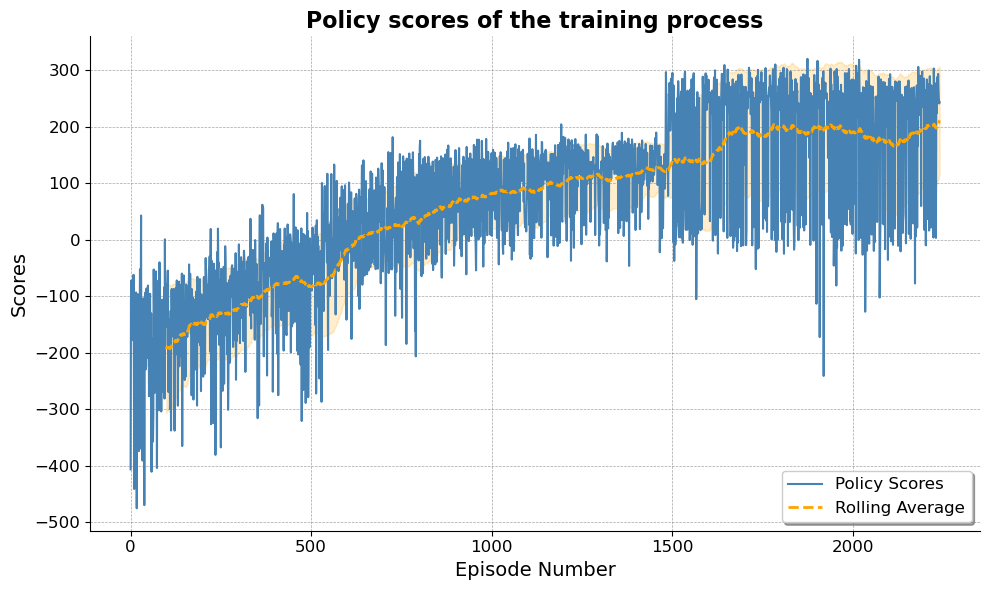

In [223]:
fig, ax = plt.subplots(figsize=(10, 6))

scores.plot(ax=ax, label="Policy Scores", color='steelblue', linewidth=1.5)
(scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax, color='orange', linewidth=2, linestyle='--'))

ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_title("Policy scores of the training process", fontsize=16, fontweight='bold')
ax.set_xlabel("Episode Number", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True, fancybox=True)

ax.fill_between(scores.index, 
                scores.rolling(window=100).mean() - scores.rolling(window=100).std(),
                scores.rolling(window=100).mean() + scores.rolling(window=100).std(),
                color='orange', alpha=0.2, label='Rolling Std Dev')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [224]:
def evaluate(policy, env, num_episodes, max_steps):
    """
    Function to evaluate the performance of a policy.

    """
    all_rewards = []
    all_steps = []
    
    for i_episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            action, _ = policy.act(state)
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            if done:
                break
                
        all_rewards.append(episode_reward)
        all_steps.append(step + 1)

    avg_reward = np.mean(all_rewards)
    avg_steps = np.mean(all_steps)
    print(f"Evaluation over {num_episodes} episodes:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Episode Length: {avg_steps:.2f}")
    return avg_reward, avg_steps

In [225]:
avg_reward, avg_steps = evaluate(LL_policy, env, LL_hyperparameters["n_evaluation_episodes"],
                                       LL_hyperparameters["max_steps"])

Evaluation over 10 episodes:
Average Reward: 211.86
Average Episode Length: 328.10


# 4. Save the Model

In [226]:
path = './third_model'

In [227]:
torch.save(LL_policy.state_dict(), path)

# 5. Load a Model

In [228]:
path_to_load = './third_model'

In [229]:
model = PolicyNetwork(LL_hyperparameters["state_space"], LL_hyperparameters["action_space"],
                           LL_hyperparameters["h_size"]).to(device)
model.load_state_dict(torch.load(path_to_load))

<All keys matched successfully>

In [230]:
avg_reward, avg_steps = evaluate(LL_policy, env, LL_hyperparameters["n_evaluation_episodes"],
                                       LL_hyperparameters["max_steps"])

Evaluation over 10 episodes:
Average Reward: 200.00
Average Episode Length: 294.80
